
# Classifier Chain

Example of using classifier chain on a multilabel dataset.

For this example we will use the `yeast
<https://www.openml.org/d/40597>`_ dataset which contains
2417 datapoints each with 103 features and 14 possible labels. Each
data point has at least one label. As a baseline we first train a logistic
regression classifier for each of the 14 labels. To evaluate the performance of
these classifiers we predict on a held-out test set and calculate the
`jaccard score <jaccard_similarity_score>` for each sample.

Next we create 10 classifier chains. Each classifier chain contains a
logistic regression model for each of the 14 labels. The models in each
chain are ordered randomly. In addition to the 103 features in the dataset,
each model gets the predictions of the preceding models in the chain as
features (note that by default at training time each model gets the true
labels as features). These additional features allow each chain to exploit
correlations among the classes. The Jaccard similarity score for each chain
tends to be greater than that of the set independent logistic models.

Because the models in each chain are arranged randomly there is significant
variation in performance among the chains. Presumably there is an optimal
ordering of the classes in a chain that will yield the best performance.
However we do not know that ordering a priori. Instead we can construct an
voting ensemble of classifier chains by averaging the binary predictions of
the chains and apply a threshold of 0.5. The Jaccard similarity score of the
ensemble is greater than that of the independent models and tends to exceed
the score of each chain in the ensemble (although this is not guaranteed
with randomly ordered chains).


In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import fetch_openml
from sklearn.multioutput import ClassifierChain
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import jaccard_score
from sklearn.linear_model import LogisticRegression

In [7]:
# Load a multi-label dataset from https://www.openml.org/d/40597
X, Y = fetch_openml('yeast', version=4, return_X_y=True)
Y = Y == 'TRUE'
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2,
                                                    random_state=0)

In [7]:
X

array([[ 0.004168, -0.170975, -0.156748, ..., -0.018312,  0.030126,
         0.124722],
       [-0.103956,  0.011879, -0.098986, ..., -0.041471, -0.079758,
         0.017161],
       [ 0.509949,  0.401709,  0.293799, ...,  0.02671 , -0.066565,
        -0.122352],
       ...,
       [ 0.082526, -0.095571, -0.022019, ..., -0.066957,  0.260121,
        -0.125303],
       [-0.13083 ,  0.008868, -0.009457, ..., -0.122332, -0.022453,
         0.001953],
       [-0.171578, -0.066536,  0.168206, ..., -0.083342, -0.063135,
         0.01881 ]])

In [10]:
Y_train

array([[ True,  True, False, ...,  True,  True, False],
       [False,  True,  True, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ...,  True,  True, False],
       [False, False,  True, ...,  True,  True, False],
       [ True,  True,  True, ..., False, False, False]])

In [11]:
# Fit an independent logistic regression model for each class using the
# OneVsRestClassifier wrapper.
base_lr = LogisticRegression()
ovr = OneVsRestClassifier(base_lr)
ovr.fit(X_train, Y_train)
Y_pred_ovr = ovr.predict(X_test)
ovr_jaccard_score = jaccard_score(Y_test, Y_pred_ovr, average='samples'); ovr_jaccard_score

0.47496720451265906

In [12]:
Y_pred_ovr

array([[1, 0, 0, ..., 1, 1, 0],
       [0, 0, 1, ..., 1, 1, 0],
       [1, 0, 0, ..., 1, 1, 0],
       ...,
       [0, 1, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 1, 0],
       [1, 1, 0, ..., 1, 1, 0]])

In [13]:
# Fit an ensemble of logistic regression classifier chains and take the
chains = [ClassifierChain(base_lr, order='random', random_state=i)
          for i in range(10)]
for chain in chains:
    chain.fit(X_train, Y_train)

Y_pred_chains = np.array([chain.predict(X_test) for chain in
                          chains])
chain_jaccard_scores = [jaccard_score(Y_test, Y_pred_chain >= .5,
                                      average='samples')
                        for Y_pred_chain in Y_pred_chains]

In [15]:
chain_jaccard_scores

[0.4914256198347107,
 0.46160632296995935,
 0.49600468975468975,
 0.48983093926275745,
 0.49027941755214477,
 0.4837262828998366,
 0.4832737051745316,
 0.48941443657352746,
 0.4902173297317925,
 0.4893021120293848]

In [16]:
# take the average prediction of all the chains.

Y_pred_ensemble = Y_pred_chains.mean(axis=0)
ensemble_jaccard_score = jaccard_score(Y_test,
                                       Y_pred_ensemble >= .5,
                                       average='samples')

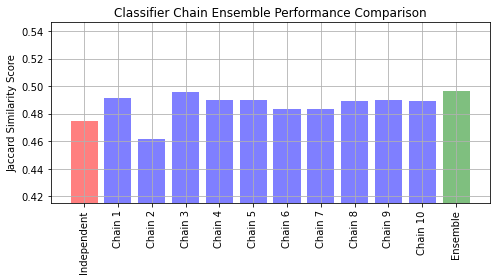

In [17]:
model_scores = [ovr_jaccard_score] + chain_jaccard_scores
model_scores.append(ensemble_jaccard_score)

model_names = ('Independent',
               'Chain 1',
               'Chain 2',
               'Chain 3',
               'Chain 4',
               'Chain 5',
               'Chain 6',
               'Chain 7',
               'Chain 8',
               'Chain 9',
               'Chain 10',
               'Ensemble')

x_pos = np.arange(len(model_names))

# Plot the Jaccard similarity scores for the independent model, each of the
# chains, and the ensemble (note that the vertical axis on this plot does
# not begin at 0).

fig, ax = plt.subplots(figsize=(7, 4))
ax.grid(True)
ax.set_title('Classifier Chain Ensemble Performance Comparison')
ax.set_xticks(x_pos)
ax.set_xticklabels(model_names, rotation='vertical')
ax.set_ylabel('Jaccard Similarity Score')
ax.set_ylim([min(model_scores) * .9, max(model_scores) * 1.1])
colors = ['r'] + ['b'] * len(chain_jaccard_scores) + ['g']
ax.bar(x_pos, model_scores, alpha=0.5, color=colors)
plt.tight_layout()
plt.show()

###  accuracy_score


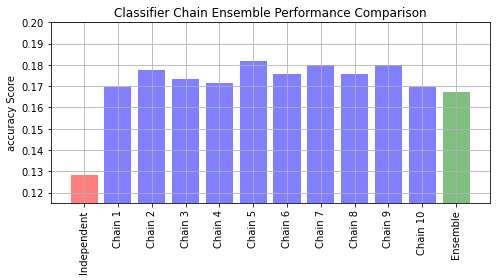

In [8]:
from sklearn.metrics import accuracy_score

# Fit an independent logistic regression model for each class using the
# OneVsRestClassifier wrapper.
base_lr = LogisticRegression()
ovr = OneVsRestClassifier(base_lr)
ovr.fit(X_train, Y_train)
Y_pred_ovr = ovr.predict(X_test)
ovr_accuracy_score = accuracy_score(Y_test, Y_pred_ovr)

# Fit an ensemble of logistic regression classifier chains and take the
# take the average prediction of all the chains.
chains = [ClassifierChain(base_lr, order='random', random_state=i)
          for i in range(10)]
for chain in chains:
    chain.fit(X_train, Y_train)

Y_pred_chains = np.array([chain.predict(X_test) for chain in
                          chains])
chain_accuracy_scores = [accuracy_score(Y_test, Y_pred_chain >= .5)
                        for Y_pred_chain in Y_pred_chains]

Y_pred_ensemble = Y_pred_chains.mean(axis=0)
ensemble_accuracy_score = accuracy_score(Y_test,
                                       Y_pred_ensemble >= .5)

model_scores = [ovr_accuracy_score] + chain_accuracy_scores
model_scores.append(ensemble_accuracy_score)

model_names = ('Independent',
               'Chain 1',
               'Chain 2',
               'Chain 3',
               'Chain 4',
               'Chain 5',
               'Chain 6',
               'Chain 7',
               'Chain 8',
               'Chain 9',
               'Chain 10',
               'Ensemble')

x_pos = np.arange(len(model_names))

# Plot the accuracy scores for the independent model, each of the
# chains, and the ensemble (note that the vertical axis on this plot does
# not begin at 0).

fig, ax = plt.subplots(figsize=(7, 4))
ax.grid(True)
ax.set_title('Classifier Chain Ensemble Performance Comparison')
ax.set_xticks(x_pos)
ax.set_xticklabels(model_names, rotation='vertical')
ax.set_ylabel('accuracy Score')
ax.set_ylim([min(model_scores) * .9, max(model_scores) * 1.1])
colors = ['r'] + ['b'] * len(chain_accuracy_scores) + ['g']
ax.bar(x_pos, model_scores, alpha=0.5, color=colors)
plt.tight_layout()
plt.show()